# Neural Network from scratch  

In this notebook, we will implement a fully parameterized neural network from scratch. We will be using only few libraries like numpy, pandas, matplotlib and sklearn for scale and show the accuracy (No API for neural network are used).

We will fit and test this neural netwrok to classify images from FASHION-MNIST dataset.

## import libraries and load the dataset

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from statistics import mean

In [2]:
path = "./data/" 

filename_read_train = os.path.join(path, "fashion-mnist_train.csv")
filename_read_test = os.path.join(path, "fashion-mnist_test.csv")

train_data = pd.read_csv(filename_read_train, na_values=['NA', '?'])
test_data = pd.read_csv(filename_read_test, na_values=['NA', '?'])

In [3]:
X_train = np.array(train_data.loc[:, train_data.columns!='label'])
y_train = pd.get_dummies(train_data["label"]).values.astype(np.float32)

X_test = np.array(test_data.loc[:, test_data.columns!='label'])
y_test = pd.get_dummies(test_data["label"]).values.astype(np.float32)

In [4]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [5]:
# Scale the data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Implement NeuralNetwork Class

In [6]:
class NeuralNetwork:
    
    # constructer takes as input: the network size(list of nodes for each layer), list of activation function for each layer
    # learning rate
    def __init__(self,
                network_size,
                activation_fct,
                learning_rate=0.01):
        self.network_size = network_size
        self.activation_fct = activation_fct
        self.learning_rate = learning_rate
        # L: lenght of the network
        self.L = len(network_size)
        self.weight_params = {}
        # list to keep track of costs
        self.costs = []
        # dic for store the value and derivatives and use it inside the class
        self.cache = {}
        # method to initialize the weigths and biases
        self.initialize_weigths()
        
    
    # initialize weights and biases
    def initialize_weigths(self, init_method='xavier'):
        if init_method == 'xavier':
            for layer in range(self.L - 1):
                self.weight_params[f'b{layer + 1}'] = np.ones((1, self.network_size[layer + 1]))
                self.weight_params[f'w{layer + 1}'] = np.random.randn(self.network_size[layer], self.network_size[layer + 1]) / np.sqrt(self.network_size[layer])

        elif init_method == 'He':
            for layer in range(self.L - 1):
                self.weight_params[f'b{layer + 1}'] = np.ones((1, self.network_size[layer + 1]))
                self.weight_params[f'w{layer + 1}'] = np.random.randn(self.network_size[layer], self.network_size[layer + 1]) / np.sqrt(self.network_size[layer]/2)
        
        else:
            for layer in range(self.L - 1):
                self.weight_params[f'b{layer + 1}'] = np.ones((1, self.network_size[layer + 1]))
                self.weight_params[f'w{layer + 1}'] = 2*np.random.random((self.network_size[layer], self.network_size[layer + 1])) - 1
                
    
    # activation functions and there derivatives
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivation(self, x):
        return x * (1-x)

    def ReLU(self, x):
        return np.maximum(0,x)

    def ReLU_derivation(self, x):
        return 1.0*(x>0)

    def softmax(self, s):
        exps = np.exp(s - np.max(s, axis=1, keepdims=True))
        return exps/np.sum(exps, axis=1, keepdims=True)
    
    # cross entropy and error to use it with softmax in output layer
    def cross_entropy(self, pred, real):
        n_samples = real.shape[0]
        res = pred - real
        return res/n_samples
    
    def error(self, yHat, y):
        cost = -np.mean(y * np.log(yHat + 1e-8))
        return cost
    
    # method takes as input X, y, batch_size and seeds, to return mini_batchs according to the size of batchs, and use the seeds
    # to get every time diffrenet batchs
    def get_minibatches_train(self, X, y, batch_size, seeds):
        size_split = int(len(X)/batch_size)
        mini_batches = []
        indexes = np.arange(len(X))
        np.random.seed(seeds)
        np.random.shuffle(indexes)

        for i in range(size_split):

            X_mini = X[indexes[i * batch_size: (i+1) * batch_size]]
            y_mini = y[indexes[i * batch_size: (i+1) * batch_size]]
            mini_batch = (X_mini, y_mini)
            mini_batches.append(mini_batch)

        return mini_batches
    
    # Feedforward method, takes as input the values of X
    def _feedforward(self, X):
        
        # initialize value small x as big X, so we can use it in the loop and update it to calculate z and a
        x = X
        
        # test the loop and make sure it creates the correct value of z and a
        """
        for layer in range(1, self.L - 1):
            print(f'z{layer} = {x} * w{layer}')
            if self.activation_fct[layer - 1] == 'ReLU':
                print(f'a{layer} = ReLU(z{layer})')
                
            elif self.activation_fct[layer - 1] == 'sigmoid':
                print(f'a{layer} = sigmoid(z{layer})')
            
            
            x = f'a{layer}'
                
        """
        # Loop over the number of layer, except the last layer, because we're using softmax since it is a classification
        for layer in range(1, self.L - 1):
            # z = x.w + b
            self.cache[f'z{layer}'] = np.dot(x, self.weight_params[f'w{layer}']) + self.weight_params[f'b{layer}']
            
            # check the activation function
            # a = activation(z)
            
            if self.activation_fct[layer - 1] == 'ReLU':
                self.cache[f'a{layer}'] = self.ReLU(self.cache[f'z{layer}'])
                
            elif self.activation_fct[layer - 1] == 'sigmoid':
                self.cache[f'a{layer}'] = self.sigmoid(self.cache[f'z{layer}'])
            
            # update the value of x to be x = a
            x = self.cache[f'a{layer}']
            
        # Now calculate the z and a to the last layer using softmax, so we will get propability distribution between 0 and 1
        self.cache[f'z{self.L - 1}'] = np.dot(x, self.weight_params[f'w{self.L - 1}']) + self.weight_params[f'b{self.L - 1}']
        self.cache[f'a{self.L - 1}'] = self.softmax(self.cache[f'z{self.L - 1}'])
        
        
        # return the last value of a, so it's the output of softmax, in other words, yHat or predicted y
        return self.cache[f'a{self.L - 1}']
    
    # backward function takes as inputs X and y
    def _backward(self, X, y):
        
        # test the loop and make sure it creates the correct value of z_delta and a_delta
        """
        for layer in range(self.L - 2, 0, -1):
            print(f'z{layer}_delta = a{layer + 1}_delta * w{layer+1}.T')
            
            print(self.activation_fct[layer-1])
            if self.activation_fct[layer-1] == 'ReLU':
                print(f'a{layer}_delta = z{layer}_delta * dev_ReLU(a{layer})')
                
            elif self.activation_fct[layer-1] == 'sigmoid':
                print(f'a{layer}_delta = z{layer}_delta * dev_sigmoid(a{layer})')
        
        
        """
        #print(cache[f'a{self.L - 1}'])
        #loss = self.error(self.cache[f'a{self.L - 1}'], y)
        
        self.cache[f'a{self.L - 1}_delta'] = self.cross_entropy(self.cache[f'a{self.L - 1}'], y)
        self.cache[f'z{self.L - 1}_delta'] = self.cross_entropy(self.cache[f'z{self.L - 1}'], y)
        
        for layer in range(self.L - 2, 0, -1):
            #print(layer)
            self.cache[f'z{layer}_delta'] = np.dot( self.cache[f'a{layer + 1}_delta'], self.weight_params[f'w{layer+1}'].T)
            
            #print(self.activation_fct[layer - 1])
            if self.activation_fct[layer - 1] == 'ReLU':
                self.cache[f'a{layer}_delta'] = self.cache[f'z{layer}_delta'] * self.ReLU_derivation(self.cache[f'a{layer}'])
                
            elif self.activation_fct[layer - 1] == 'sigmoid':
                self.cache[f'a{layer}_delta'] = self.cache[f'z{layer}_delta'] * self.sigmoid_derivation(self.cache[f'a{layer}'])

        #print(self.cache.keys())
        
    # Method to fit the data, takes as input X, y, number of epochs, print epochs every loss_every, optimizer method, and batch_size
    def fit(self, X, y, nb_epochs = 500, loss_every=50, optimizer='GD', stop=0.02,batch_size=None):
        
        # if batch_size not given, then it's a normal gradient descent
        # if it is > len(X) so batch_size = len(X) and if < 0 fo it's = 1,(SGD)
        if batch_size == None:
            batch_size = len(X)
        
        if batch_size > len(X):
            batch_size = len(X)
        
        if batch_size <= 1:
            batch_size = 1
        
        if optimizer == 'GD':
            for epoch in range(nb_epochs):
                
                mini_batches = self.get_minibatches_train(X, y, batch_size, epoch)
                mini_batch_cost = []
                
                # for every batch in mini_batchs run forward and backward and update the weights and biases
                for mini_batch in mini_batches:
                    X_batch, y_batch = mini_batch
                    yHat = self._feedforward(X_batch)
                    self._backward(X_batch, y_batch) 
                    loss = self.error(yHat, y_batch)
                    a = X_batch.T
                    
                    # m is the number of samples
                    m = X_batch.shape[0]
                    
                    # int(len(self.weight_params)/2) is the number of w and b to update
                    for layer in range(1, int(len(self.weight_params)/2)):
                        
                        self.weight_params[f'w{layer}'] -= self.learning_rate  * np.dot(a, self.cache[f'a{layer}_delta'])
                        self.weight_params[f'b{layer}'] -= self.learning_rate  * np.sum(self.cache[f'z{layer}_delta'], axis = 0, keepdims = True)
                        a = self.cache[f'a{layer}'].T
                    
                    # append the loss to the cost list and to mini_batchs_cost to stop it accourding to stoping creteria
                    mini_batch_cost.append(loss)
                    self.costs.append(loss)
                
                
                #self.costs.append(mean(mini_batch_cost))
                
                # print loss 
                if epoch % loss_every == 0:
                        #print(f'epoch {epoch}: |||| Loss = {round(mean(mini_batch_cost), 5)}')
                        print("Epoch: {} - Loss:{:.4f}".format(epoch, mean(mini_batch_cost)))
                        print('=======================================================================')
                
                # check the loss and stop teh network if loss less then stop, default = 0.02
                if mean(mini_batch_cost) < stop:
                    break
        
        """
        for epoch in range(nb_epochs):
            
            yHat = self._feedforward(X)
            #print(self.error(yHat, y))
            self._backward(X, y) 
            
            loss = self.error(yHat, y)
            
            a = X.T
            for layer in range(1, len(self.weight_params)):
                self.weight_params[f'w{layer}'] -= self.learning_rate * np.dot(a, self.cache[f'a{layer}_delta'])
                a = self.cache[f'a{layer}'].T
            
            if epoch % loss_every == 0:
                print(f'epoch {epoch}: {loss}')
                
            self.costs.append(loss)
         """       
        
    # predict method return yHat
    def predict(self, X):
        yHat = self._feedforward(X)
        yHat = np.argmax(yHat, axis=1)
        return yHat
    
    # method to check accuracy
    def check_accuracy(self, y, yHat):
        y_true = np.argmax(y, axis=1)
        score = accuracy_score(y_true, yHat)
        return score * 100
    
    # plot the costs
    def plot_cost(self, title, xlabel='epochs'):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.xlabel(xlabel)
        plt.ylabel("cost")
        plt.title(title)
        plt.show()
        
    
    def model_summary(self):
        print(f"Input features = {self.network_size[0]} \nOutput labels = {self.network_size[-1]}\n")
        for layer in range(len(self.activation_fct)):
            
            if layer == len(self.activation_fct):
                print(f"Output Layer {layer} \nNumber of nodes = {self.network_size[layer + 1]} \nActivation function: {self.activation_fct[layer]}")
            
            else:
                print(f"Hidden Layer {layer} \nNumber of nodes = {self.network_size[layer + 1]} \nweight shape: {self.weight_params[f'w{layer + 1}'].shape} \nBias Shape {self.weight_params[f'b{layer + 1}'].shape} \nActivation function: {self.activation_fct[layer]}\n")
    
        
    # method to print the images with the prediction and if its true or false
    def plot_images_with_prediction(self, test_data, y_test, yHat):
        images = test_data.drop("label", axis=1).values
        images = np.reshape(images,(10000,28,28))
        y_real = np.argmax(y_test, axis=1)
        label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        ytest = test_data.label.values
        plt.figure(figsize=(15,15))
        random = random.randint(0, test_data.shape[0] - 26)
        for i in range(random, random+24):
            plt.subplot(5,5,i+1) 
            plt.xticks([]) 
            plt.yticks([]) 
            plt.grid(False) 
            
            plt.imshow(images[i],cmap='gray')
            if yHat[i] == y_real[i]: 
                plt.xlabel(f'TRUE: {label_names[yHat[i]]}', c='b')
            else:
                plt.xlabel(f'False: {label_names[ytest[i]]}-{label_names[yHat[i]]}', c='r')

        plt.show()

## Fit the Model with 1 hidden layer with 500 nodes and Sigmoid activation

In [7]:
network_size = [784, 500, 10]
activation_fct = ['sigmoid', 'softmax']
nn0 = NeuralNetwork(network_size, activation_fct)
nn0.model_summary()

Input features = 784 
Output labels = 10

Hidden Layer 0 
Number of nodes = 500 
weight shape: (784, 500) 
Bias Shape (1, 500) 
Activation function: sigmoid

Hidden Layer 1 
Number of nodes = 10 
weight shape: (500, 10) 
Bias Shape (1, 10) 
Activation function: softmax



In [8]:
nn0.fit(X_train, y_train, nb_epochs = 100 ,loss_every=5, stop=0.025)

Epoch: 0 - Loss:0.2404
Epoch: 5 - Loss:0.2398
Epoch: 10 - Loss:0.2392
Epoch: 15 - Loss:0.2386
Epoch: 20 - Loss:0.2380
Epoch: 25 - Loss:0.2374
Epoch: 30 - Loss:0.2368
Epoch: 35 - Loss:0.2362
Epoch: 40 - Loss:0.2356
Epoch: 45 - Loss:0.2351
Epoch: 50 - Loss:0.2345
Epoch: 55 - Loss:0.2340
Epoch: 60 - Loss:0.2335
Epoch: 65 - Loss:0.2329
Epoch: 70 - Loss:0.2324
Epoch: 75 - Loss:0.2319
Epoch: 80 - Loss:0.2314
Epoch: 85 - Loss:0.2309
Epoch: 90 - Loss:0.2304
Epoch: 95 - Loss:0.2299


Accuracy Score:  11.559999999999999 %


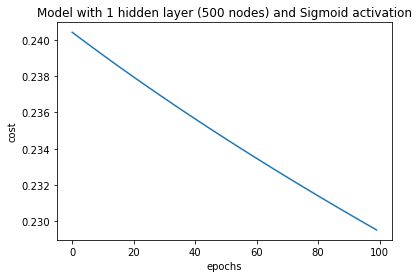

In [9]:
yHat = nn0.predict(X_test)
print('Accuracy Score: ', nn0.check_accuracy(y_test, yHat), '%')
nn0.plot_cost(title='Model with 1 hidden layer (500 nodes) and Sigmoid activation')

## Fit the Model with 1 hidden layer with 500 nodes and ReLU activation

In [10]:
network_size = [784, 500, 10]
activation_fct = ['ReLU', 'softmax']
nn1 = NeuralNetwork(network_size, activation_fct, learning_rate=0.1)
nn1.model_summary()

Input features = 784 
Output labels = 10

Hidden Layer 0 
Number of nodes = 500 
weight shape: (784, 500) 
Bias Shape (1, 500) 
Activation function: ReLU

Hidden Layer 1 
Number of nodes = 10 
weight shape: (500, 10) 
Bias Shape (1, 10) 
Activation function: softmax



In [11]:
nn1.fit(X_train, y_train, nb_epochs = 100 ,loss_every=5, stop=0.025)

Epoch: 0 - Loss:0.2623
Epoch: 5 - Loss:0.1658
Epoch: 10 - Loss:0.1351
Epoch: 15 - Loss:0.1187
Epoch: 20 - Loss:0.1086
Epoch: 25 - Loss:0.1016
Epoch: 30 - Loss:0.0964
Epoch: 35 - Loss:0.0924
Epoch: 40 - Loss:0.0892
Epoch: 45 - Loss:0.0865
Epoch: 50 - Loss:0.0842
Epoch: 55 - Loss:0.0822
Epoch: 60 - Loss:0.0804
Epoch: 65 - Loss:0.0789
Epoch: 70 - Loss:0.0775
Epoch: 75 - Loss:0.0762
Epoch: 80 - Loss:0.0751
Epoch: 85 - Loss:0.0740
Epoch: 90 - Loss:0.0731
Epoch: 95 - Loss:0.0722


Accuracy Score:  77.64999999999999


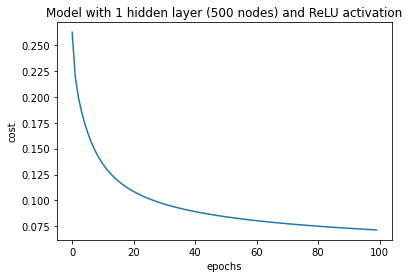

In [12]:
yHat = nn1.predict(X_test)
print('Accuracy Score: ', nn1.check_accuracy(y_test, yHat))
nn1.plot_cost(title='Model with 1 hidden layer (500 nodes) and ReLU activation')

Lets increase the number of epochs

In [13]:
nn1.fit(X_train, y_train, nb_epochs = 500 ,loss_every=5, stop=0.025)

Epoch: 0 - Loss:0.0714
Epoch: 5 - Loss:0.0706
Epoch: 10 - Loss:0.0699
Epoch: 15 - Loss:0.0692
Epoch: 20 - Loss:0.0685
Epoch: 25 - Loss:0.0679
Epoch: 30 - Loss:0.0674
Epoch: 35 - Loss:0.0668
Epoch: 40 - Loss:0.0663
Epoch: 45 - Loss:0.0659
Epoch: 50 - Loss:0.0654
Epoch: 55 - Loss:0.0650
Epoch: 60 - Loss:0.0645
Epoch: 65 - Loss:0.0641
Epoch: 70 - Loss:0.0637
Epoch: 75 - Loss:0.0634
Epoch: 80 - Loss:0.0630
Epoch: 85 - Loss:0.0627
Epoch: 90 - Loss:0.0623
Epoch: 95 - Loss:0.0620
Epoch: 100 - Loss:0.0617
Epoch: 105 - Loss:0.0614
Epoch: 110 - Loss:0.0611
Epoch: 115 - Loss:0.0609
Epoch: 120 - Loss:0.0606
Epoch: 125 - Loss:0.0603
Epoch: 130 - Loss:0.0601
Epoch: 135 - Loss:0.0598
Epoch: 140 - Loss:0.0596
Epoch: 145 - Loss:0.0594
Epoch: 150 - Loss:0.0592
Epoch: 155 - Loss:0.0589
Epoch: 160 - Loss:0.0587
Epoch: 165 - Loss:0.0585
Epoch: 170 - Loss:0.0583
Epoch: 175 - Loss:0.0581
Epoch: 180 - Loss:0.0580
Epoch: 185 - Loss:0.0578
Epoch: 190 - Loss:0.0576
Epoch: 195 - Loss:0.0574
Epoch: 200 - Loss:0.05

Epoch: 425 - Loss:0.0523
Epoch: 430 - Loss:0.0522
Epoch: 435 - Loss:0.0521
Epoch: 440 - Loss:0.0521
Epoch: 445 - Loss:0.0520
Epoch: 450 - Loss:0.0519
Epoch: 455 - Loss:0.0518
Epoch: 460 - Loss:0.0518
Epoch: 465 - Loss:0.0517
Epoch: 470 - Loss:0.0516
Epoch: 475 - Loss:0.0516
Epoch: 480 - Loss:0.0515
Epoch: 485 - Loss:0.0514
Epoch: 490 - Loss:0.0514
Epoch: 495 - Loss:0.0513


Accuracy Score:  83.15


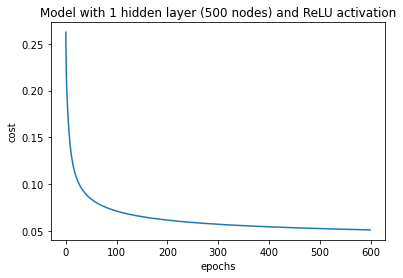

In [14]:
yHat = nn1.predict(X_test)
print('Accuracy Score: ', nn1.check_accuracy(y_test, yHat))
nn1.plot_cost(title='Model with 1 hidden layer (500 nodes) and ReLU activation')

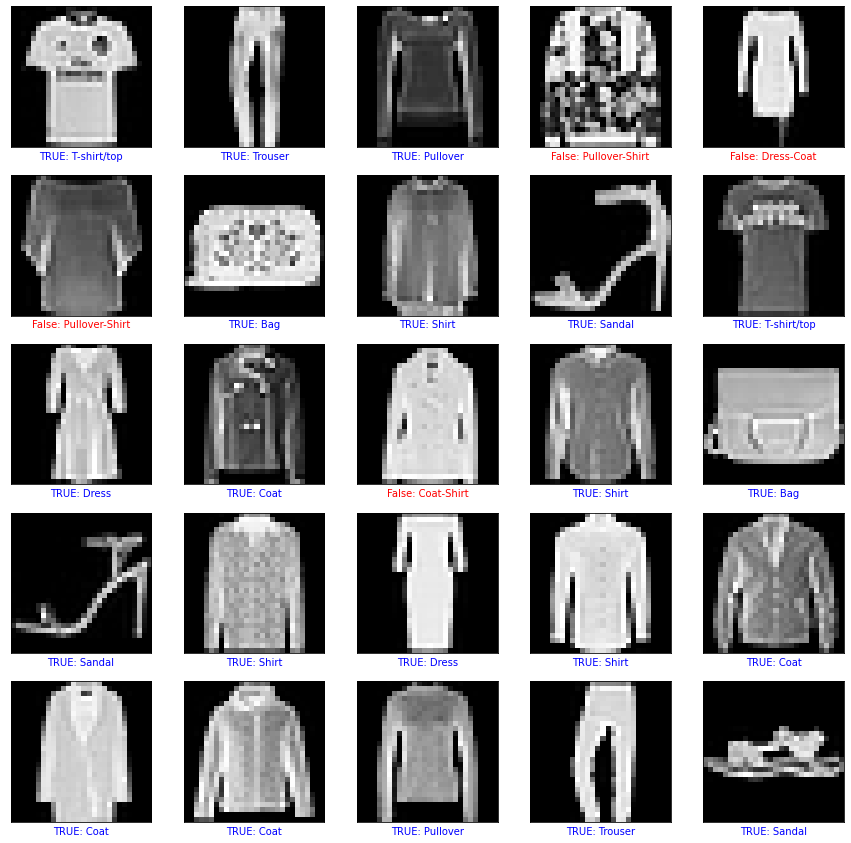

In [15]:
nn1.plot_images_with_prediction(test_data, y_test, yHat)

## Fit the Model with 1 hidden layer with 500, ReLU activation function and mini batch as oprimazation

In [16]:
network_size = [784, 500, 10]
activation_fct = ['ReLU', 'softmax']
nn2 = NeuralNetwork(network_size, activation_fct, learning_rate=0.1)

In [17]:
nn2.fit(X_train, y_train, nb_epochs = 100, loss_every=50, batch_size = 100, stop=0.025)

Epoch: 0 - Loss:0.0681
Epoch: 50 - Loss:0.0318


Accuracy Score:  88.07000000000001


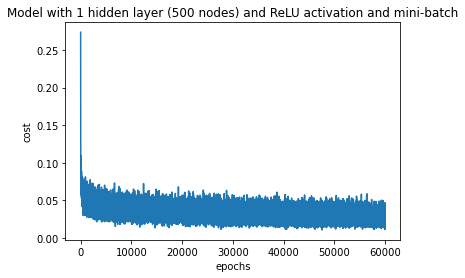

In [18]:
yHat = nn2.predict(X_test)
print('Accuracy Score: ', nn2.check_accuracy(y_test, yHat))
nn2.plot_cost(title='Model with 1 hidden layer (500 nodes) and ReLU activation and mini-batch')

## Fit the Model with 1 hidden layer with 500 nodes, ReLU activation function with SGD

In [19]:
network_size = [784, 500, 10]
activation_fct = ['ReLU', 'softmax']
nn3 = NeuralNetwork(network_size, activation_fct)

In [20]:
nn3.fit(X_train, y_train, nb_epochs = 100, loss_every=1, batch_size = 1, stop=0.025)

Epoch: 0 - Loss:0.0521
Epoch: 1 - Loss:0.0415
Epoch: 2 - Loss:0.0382
Epoch: 3 - Loss:0.0361
Epoch: 4 - Loss:0.0344
Epoch: 5 - Loss:0.0332
Epoch: 6 - Loss:0.0320
Epoch: 7 - Loss:0.0312
Epoch: 8 - Loss:0.0303
Epoch: 9 - Loss:0.0296
Epoch: 10 - Loss:0.0290
Epoch: 11 - Loss:0.0282
Epoch: 12 - Loss:0.0277
Epoch: 13 - Loss:0.0272
Epoch: 14 - Loss:0.0267
Epoch: 15 - Loss:0.0263
Epoch: 16 - Loss:0.0258
Epoch: 17 - Loss:0.0255
Epoch: 18 - Loss:0.0251
Epoch: 19 - Loss:0.0248


Accuracy Score:  88.96


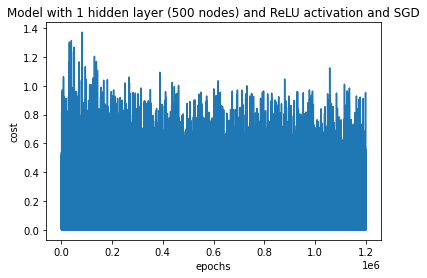

In [21]:
yHat = nn3.predict(X_test)
print('Accuracy Score: ', nn3.check_accuracy(y_test, yHat))
nn3.plot_cost(title='Model with 1 hidden layer (500 nodes) and ReLU activation and SGD')

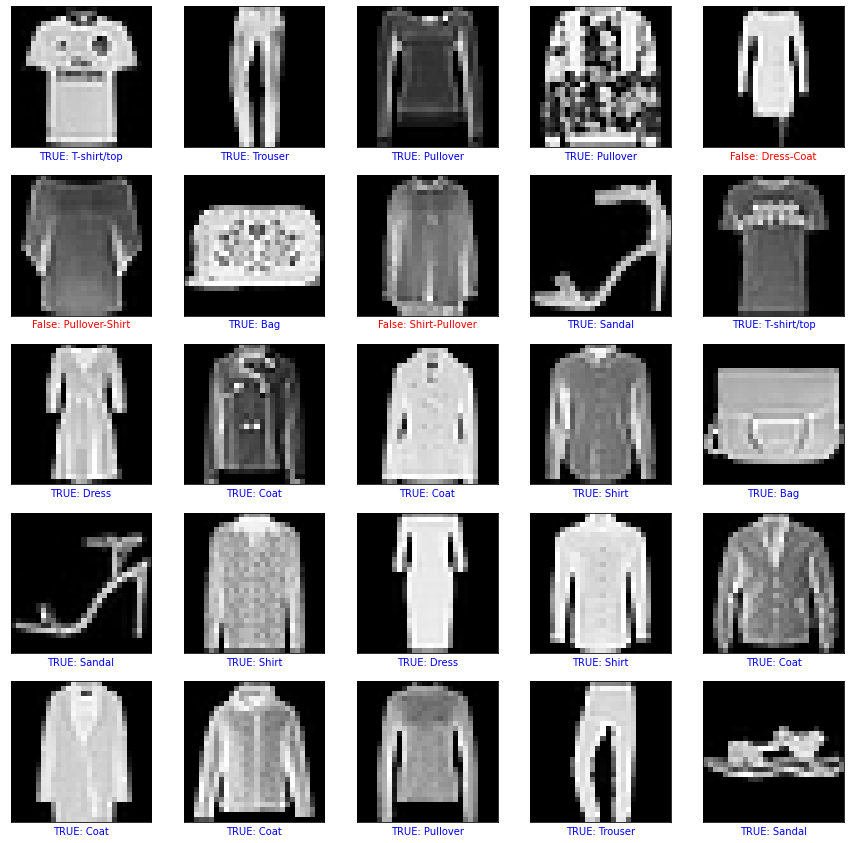

In [22]:
nn3.plot_images_with_prediction(test_data, y_test, yHat)

# Fit the Model with 2 hidden layer with 500 and 500 nodes, ReLU activation function with mini-batchs

In [23]:
network_size = [784, 500, 500,  10]
activation_fct = ['ReLU', 'ReLU', 'softmax']
nn4 = NeuralNetwork(network_size, activation_fct, learning_rate=0.1)
nn4.model_summary()

Input features = 784 
Output labels = 10

Hidden Layer 0 
Number of nodes = 500 
weight shape: (784, 500) 
Bias Shape (1, 500) 
Activation function: ReLU

Hidden Layer 1 
Number of nodes = 500 
weight shape: (500, 500) 
Bias Shape (1, 500) 
Activation function: ReLU

Hidden Layer 2 
Number of nodes = 10 
weight shape: (500, 10) 
Bias Shape (1, 10) 
Activation function: softmax



In [24]:
nn4.fit(X_train, y_train, nb_epochs = 500, loss_every=10, batch_size = 100, stop=0.025)

Epoch: 0 - Loss:0.0648
Epoch: 10 - Loss:0.0309
Epoch: 20 - Loss:0.0253


Accuracy Score:  88.88000000000001


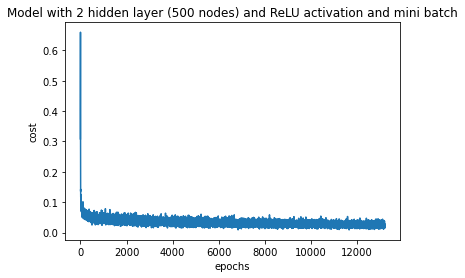

In [25]:
yHat = nn4.predict(X_test)
print('Accuracy Score: ', nn4.check_accuracy(y_test, yHat))
nn4.plot_cost(title='Model with 2 hidden layer (500 nodes) and ReLU activation and mini batch')

Try to use 0.02 as stopping 

In [26]:
network_size = [784, 500, 500,  10]
activation_fct = ['ReLU', 'ReLU', 'softmax']
nn5 = NeuralNetwork(network_size, activation_fct, learning_rate=0.1)
nn5.model_summary()

Input features = 784 
Output labels = 10

Hidden Layer 0 
Number of nodes = 500 
weight shape: (784, 500) 
Bias Shape (1, 500) 
Activation function: ReLU

Hidden Layer 1 
Number of nodes = 500 
weight shape: (500, 500) 
Bias Shape (1, 500) 
Activation function: ReLU

Hidden Layer 2 
Number of nodes = 10 
weight shape: (500, 10) 
Bias Shape (1, 10) 
Activation function: softmax



In [27]:
nn5.fit(X_train, y_train, nb_epochs = 500, loss_every=10, batch_size = 100, stop=0.02)

Epoch: 0 - Loss:0.0644
Epoch: 10 - Loss:0.0312
Epoch: 20 - Loss:0.0257
Epoch: 30 - Loss:0.0218


Accuracy Score:  89.74


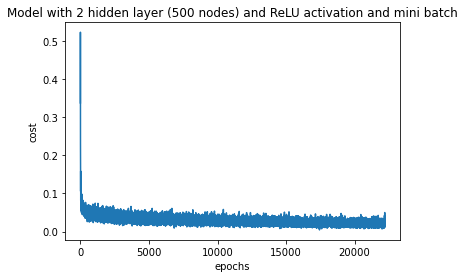

In [28]:
yHat = nn5.predict(X_test)
print('Accuracy Score: ', nn5.check_accuracy(y_test, yHat))
nn5.plot_cost(title='Model with 2 hidden layer (500 nodes) and ReLU activation and mini batch')

In [34]:
# model 0
yHat0 = nn0.predict(X_test)
accuracy_0 = nn0.check_accuracy(y_test, yHat0)

# model 1
yHat1 = nn1.predict(X_test)
accuracy_1 = nn1.check_accuracy(y_test, yHat1)

# model 2
yHat2 = nn2.predict(X_test)
accuracy_2 = nn2.check_accuracy(y_test, yHat2)

# model 3
yHat3 = nn3.predict(X_test)
accuracy_3 = nn3.check_accuracy(y_test, yHat3)

# model 4
yHat4 = nn4.predict(X_test)
accuracy_4 = nn4.check_accuracy(y_test, yHat4)

# model 5
yHat5 = nn2.predict(X_test)
accuracy_5 = nn5.check_accuracy(y_test, yHat5)

accuracy = [accuracy_0, accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5]
models = ['sigmoid act', 'ReLU act', 'ReLU mini-batch', 'ReLU SGD', '2 hidden layers minibatch', 'model 4 change stopping']

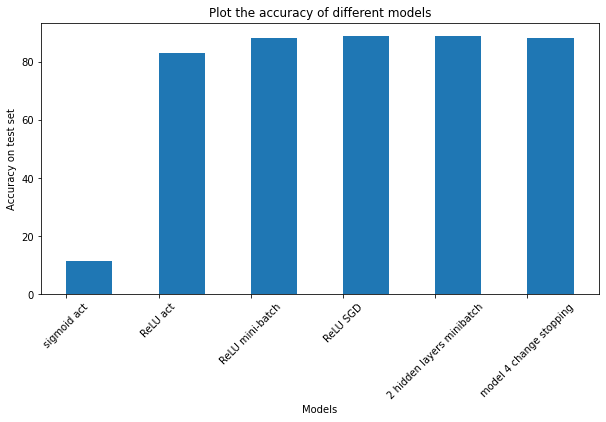

In [35]:
fig = plt.figure(figsize = (10, 5))
 
plt.bar(models, accuracy, align='edge', width = 0.5)
plt.xticks(rotation=45)
plt.xlabel("Models")
plt.ylabel("Accuracy on test set")
plt.title("Plot the accuracy of different models")
plt.show()